In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/ARC_heuristic/PlotsPaper/')
print(os.getcwd())

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1b0U2fABpE8D898NvKTrvvqqusm1peAQH/ARC_heuristic/PlotsPaper


bs cutoff 95
ls cutoff 111
tc cutoff 55
mp cutoff 56
-------------
dataset,ngate,accTest,accTrain
twoCurves,55,0.8479702021596233,0.8521110137586967
linSep,111,0.9549218399641233,0.971
twoCurves,95,0.945996558356109,0.9362660325695346
mnistPCA,56,0.9234216134617946,0.9117700482224913
-------------
[0, -1, 1, 0, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 1, 0, 1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 1, 0, 1, 0, 1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 1, 0, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0

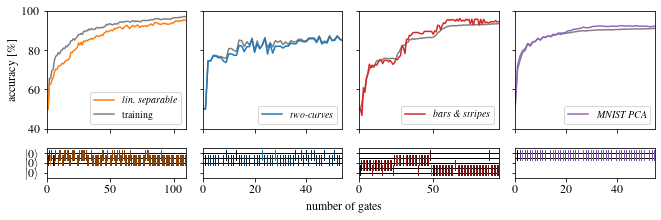

In [4]:
import numpy as np
import pylab as plt
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from matplotlib.path import Path
import matplotlib.colors
import array

import matplotlib as mpl

mpl.rcParams.update({'text.usetex':True,'font.size': 12, 'font.family': 'serif', 'font.serif': ['Times', 'Computer Modern']})



#import seaborn as sns

def readGate(gateFile,cutoff='nan'):
	qubit = []	#id of the used qubit
	weight = []	#weight by which the angle is rotated
	layer = []	#in which layer a gate is occupied (important for gates that act on two qubits)
	twoQubit = [] #indicate if a gate is a two-qubit gate or not
	gateData = open(gateFile,'r')
	layer_collect = 1
	count = 0
	for data in gateData:
		if count == cutoff:
			break
		line = data.split('\t')
		for l in range(len(line)-2):
			if line[l] == '111111': pass
			else:
				qubit.append(l)
				layer.append(layer_collect)
				weight.append(float(line[-2]))
				if line[l] == 'Rxx_x' or line[l] == 'Ryy_x' or line[l] == 'Rzz_x':
					qubit.append(l-1)
					layer.append(layer_collect)
					weight.append(float(line[-2]))
					twoQubit.append(True)
					twoQubit.append(True)
				else:
					twoQubit.append(False)
				layer_collect+=1
		if cutoff == 'nan': pass
		else:count+=1
	return [qubit,weight,layer,twoQubit]

def cutCost(cost):
	cutoff = 'nan'
	if len(cost)>2:
		for i in range(2,len(cost)):
			if abs(cost[i]-cost[i-2])<1e-3:
				cutoff = i
				break
	return cutoff


#import data
#bars-and-stripes
path = 'Data_QNN/logLossBS/'
test0 = np.genfromtxt(path+'ACC_test.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_test.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
barsStripes = [test0,test1,(test0+test1)*0.5]
test0 = np.genfromtxt(path+'ACC_train.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_train.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
barsStripes_train = [test0,test1,(test0+test1)*0.5]
barsStripes_cost_gate = np.genfromtxt(path+'Cost_collect.txt',usecols=0)
barsStripes_cost = np.genfromtxt(path+'Cost_collect.txt',usecols=1)
cutoff = cutCost(barsStripes_cost)
barsStripes_qubit,barsStripes_weight,barsStripes_layer,barsStripes_twoQ = readGate(path+'Gate_collect.txt',cutoff)
print('bs cutoff',cutoff)
if cutoff !='nan':
	barsStripes = [barsStripes[0][:cutoff],barsStripes[1][:cutoff],barsStripes[2][:cutoff]]
	barsStripes_train = [barsStripes_train[0][:cutoff],barsStripes_train[1][:cutoff],barsStripes_train[2][:cutoff]]
	barsStripes_cost_gate = barsStripes_cost_gate[:cutoff]
	barsStripes_cost = barsStripes_cost[:cutoff]

#linearly-separable 10d
path = 'Data_QNN/logLossLS/'
test0 = np.genfromtxt(path+'ACC_test.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_test.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
linearSep10d = [test0,test1,(test0+test1)*0.5]
test0 = np.genfromtxt(path+'ACC_train.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_train.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
linearSep10d_train = [test0,test1,(test0+test1)*0.5]
linearSep10d_cost_gate = np.genfromtxt(path+'Cost_collect.txt',usecols=0)
linearSep10d_cost = np.genfromtxt(path+'Cost_collect.txt',usecols=1)
cutoff = cutCost(linearSep10d_cost)
linearSep10d_qubit,linearSep10d_weight,linearSep10d_layer,linearSep20d_twoQ = readGate(path+'Gate_collect.txt',cutoff)
print('ls cutoff',cutoff)
if cutoff !='nan':
	linearSep10d = [linearSep10d[0][:cutoff],linearSep10d[1][:cutoff],linearSep10d[2][:cutoff]]
	linearSep10d_train = [linearSep10d_train[0][:cutoff],linearSep10d_train[1][:cutoff],linearSep10d_train[2][:cutoff]]
	linearSep10d_cost_gate = linearSep10d_cost_gate[:cutoff]
	linearSep10d_cost = linearSep10d_cost[:cutoff]

#two-curves 10d
path = 'Data_QNN/logLossTC/'
test0 = np.genfromtxt(path+'ACC_test.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_test.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
twoCurves10d = [test0,test1,(test0+test1)*0.5]
test0 = np.genfromtxt(path+'ACC_train.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_train.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
twoCurves10d_train = [test0,test1,(test0+test1)*0.5]
twoCurves10d_cost_gate = np.genfromtxt(path+'Cost_collect.txt',usecols=0)
twoCurves10d_cost = np.genfromtxt(path+'Cost_collect.txt',usecols=1)
cutoff = cutCost(twoCurves10d_cost)
twoCurves10d_qubit,twoCurves10d_weight,twoCurves10d_layer,twoCurves10d_twoQ = readGate(path+'Gate_collect.txt',cutoff)
print('tc cutoff',cutoff)
if cutoff !='nan':
	twoCurves10d = [twoCurves10d[0][:cutoff],twoCurves10d[1][:cutoff],twoCurves10d[2][:cutoff]]
	twoCurves10d_train = [twoCurves10d_train[0][:cutoff],twoCurves10d_train[1][:cutoff],twoCurves10d_train[2][:cutoff]]
	twoCurves10d_cost_gate = twoCurves10d_cost_gate[:cutoff]
	twoCurves10d_cost = twoCurves10d_cost[:cutoff]

#mnist-pca
path = 'Data_QNN/logLossMN/'
test0 = np.genfromtxt(path+'ACC_test.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_test.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
mnistPca = [test0,test1,(test0+test1)*0.5]
test0 = np.genfromtxt(path+'ACC_train.txt',usecols=0,skip_header=1)
test1 = np.genfromtxt(path+'ACC_train.txt',usecols=1,skip_header=1)
test0 = np.array([0.5,*test0])
test1 = np.array([0.5,*test1])
mnistPca_train = [test0,test1,(test0+test1)*0.5]
mnistPca_cost_gate = np.genfromtxt(path+'Cost_collect.txt',usecols=0)
mnistPca_cost = np.genfromtxt(path+'Cost_collect.txt',usecols=1)
cutoff = cutCost(mnistPca_cost)
mnistPca_qubit,mnistPca_weight,mnistPca_layer,mnistPca_twoQ = readGate(path+'Gate_collect.txt',cutoff)
print('mp cutoff',cutoff)
if cutoff !='nan':
	mnistPca = [mnistPca[0][:cutoff],mnistPca[1][:cutoff],mnistPca[2][:cutoff]]
	mnistPca_train = [mnistPca_train[0][:cutoff],mnistPca_train[1][:cutoff],mnistPca_train[2][:cutoff]]
	mnistPca_cost_gate = mnistPca_cost_gate[:cutoff]
	mnistPca_cost = mnistPca_cost[:cutoff]



fig = plt.figure(figsize = (11.69*0.8,8.27*0.45-0.42))
gs = gridspec.GridSpec(2,4,height_ratios=[4,1])


ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharey=ax1)
ax3 = plt.subplot(gs[2],sharey=ax1)
ax4 = plt.subplot(gs[3],sharey=ax1)
ax5 = plt.subplot(gs[4],sharex=ax1)
ax6 = plt.subplot(gs[5],sharex=ax2,sharey=ax5)
ax7 = plt.subplot(gs[6],sharex=ax3,sharey=ax5)
ax8 = plt.subplot(gs[7],sharex=ax4,sharey=ax5)

ax = [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]]

ax1.plot(np.linspace(0,len(linearSep10d[2])-1,len(linearSep10d[2])),linearSep10d[2]*100,
	'-',color='tab:orange',zorder=1,label=r'\textit{lin. separable}')
ax2.plot(np.linspace(0,len(twoCurves10d[2])-1,len(twoCurves10d[2])),twoCurves10d[2]*100,
	'-',color='tab:blue',zorder=1,label=r'\textit{two-curves}')
ax3.plot(np.linspace(0,len(barsStripes[2])-1,len(barsStripes[2])),barsStripes[2]*100,
	'-',color='tab:red',zorder=1,label=r'\textit{bars \& stripes}')
ax4.plot(np.linspace(0,len(mnistPca[2])-1,len(mnistPca[2])),mnistPca[2]*100,
	'-',color='tab:purple',zorder=1,label=r'\textit{MNIST PCA}')


ax1.plot(np.linspace(0,len(linearSep10d_train[2])-1,len(linearSep10d_train[2])),linearSep10d_train[2]*100,
	'-',label='training',color='grey',zorder=0)
ax2.plot(np.linspace(0,len(twoCurves10d_train[2])-1,len(twoCurves10d_train[2])),twoCurves10d_train[2]*100,
	'-',color='grey',zorder=0)
ax3.plot(np.linspace(0,len(barsStripes_train[2])-1,len(barsStripes_train[2])),barsStripes_train[2]*100,
	'-',color='grey',zorder=0)
ax4.plot(np.linspace(0,len(mnistPca_train[2])-1,len(mnistPca_train[2])),mnistPca_train[2]*100,
	'-',color='grey',zorder=0)

print('-------------')
print('dataset,ngate,accTest,accTrain')
print(f'twoCurves,{len(twoCurves10d[2])},{twoCurves10d[2][-1]},{twoCurves10d_train[2][-1]}')
print(f'linSep,{len(linearSep10d[2])},{linearSep10d[2][-1]},{linearSep10d_train[2][-1]}')
print(f'twoCurves,{len(barsStripes[2])},{barsStripes[2][-1]},{barsStripes_train[2][-1]}')
print(f'mnistPCA,{len(mnistPca[2])},{mnistPca[2][-1]},{mnistPca_train[2][-1]}')
print('-------------')


# two-qubit symbol
verts = [
	(0.15,-1), #lower right
    (-0.15,-1), #lower left
    (-0.15,1), #upper left
    (0.15,1), #upper right
    (0.15,-1),
	]

codes = [
    Path.MOVETO, #begin the figure in the lower right
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]
symbol = Path(verts,codes)

verts = [
	(0.15,-1), #lower right
    (-0.15,-1), #lower left
    (-0.15,1), #upper left
    (0.15,1), #upper right
    (0.15,-1),
	]

codes = [
    Path.MOVETO, #begin the figure in the lower right
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]
symbol = Path(verts,codes)





cvals = [min(twoCurves10d_weight),max(twoCurves10d_weight)]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals),['black','tab:blue']))
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

cvals = [min(linearSep10d_weight),max(linearSep10d_weight)]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals),['black','tab:orange']))
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

cvals = [min(barsStripes_weight),max(barsStripes_weight)]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals),['black','tab:red']))
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

cvals = [min(mnistPca_weight),max(mnistPca_weight)]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals),['black','tab:purple']))
cmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)




def reduceQubits(qubit,maxQubit):
	diff_qubits = []
	for i in range(len(qubit)):
		if qubit[i] == -1: qubit[i] = maxQubit
		if qubit[i] in diff_qubits: pass
		else: diff_qubits.append(qubit[i])
	print(diff_qubits,type(diff_qubits),diff_qubits.sort())
	diff_qubits = np.sort(np.array(diff_qubits))
	for i in range(len(qubit)):
		idx = np.where(np.isclose(diff_qubits,qubit[i]))
		qubit[i] = idx
	n_qubits = len(diff_qubits)
	return [qubit,n_qubits]

print(linearSep10d_qubit)
twoCurves10d_qubit,n_twoCurves10d_qubit = reduceQubits(twoCurves10d_qubit,10)
linearSep10d_qubit,n_linearSep10d_qubit = reduceQubits(linearSep10d_qubit,10)
barsStripes_qubit,n_barsStripes_qubit = reduceQubits(barsStripes_qubit,16)
mnistPca_qubit,n_mnistPca_qubit = reduceQubits(mnistPca_qubit,10)

for i in range(17):
	if i<n_linearSep10d_qubit: ax5.axhline(i+2,color='black',zorder=0,linewidth=1)
	if i< n_twoCurves10d_qubit:	ax6.axhline(i+2,color='black',zorder=0,linewidth=1)
	if i<n_barsStripes_qubit: ax7.axhline(i,color='black',zorder=0,linewidth=1)
	if i<n_mnistPca_qubit: ax8.axhline(i+3,color='black',zorder=0,linewidth=1)


#reorder qubits
for i in range(len(linearSep10d_qubit)):
    if linearSep10d_qubit[i][0][0] == 2:
        linearSep10d_qubit[i][0][0] = -1
    linearSep10d_qubit[i][0][0] = linearSep10d_qubit[i][0][0]+3
for i in range(len(twoCurves10d_qubit)):
    if twoCurves10d_qubit[i][0][0] == 2:
        twoCurves10d_qubit[i][0][0] = -1
    twoCurves10d_qubit[i][0][0] = twoCurves10d_qubit[i][0][0]+3
for i in range(len(barsStripes_qubit)):
    if barsStripes_qubit[i][0][0] == 4:
        barsStripes_qubit[i][0][0] = -1
    barsStripes_qubit[i][0][0] = barsStripes_qubit[i][0][0]+1
for i in range(len(mnistPca_qubit)):
    mnistPca_qubit[i][0][0] = mnistPca_qubit[i][0][0]+3    

ax5.scatter(linearSep10d_layer,
	linearSep10d_qubit,marker=symbol,c=linearSep10d_weight,
	edgecolors='none',cmap=cmap2,linewidth=0.01,s=40)
ax6.scatter(twoCurves10d_layer,
	twoCurves10d_qubit,marker=symbol,c=twoCurves10d_weight,
	edgecolors='none',cmap = cmap1,linewidth=0.01,s=40)
ax7.scatter(barsStripes_layer,
	barsStripes_qubit,marker=symbol,c=barsStripes_weight,
	edgecolors='none',cmap=cmap3,linewidth=0.01,s=40)
scatter=ax8.scatter(mnistPca_layer,
	mnistPca_qubit,marker=symbol,c=mnistPca_weight,
	edgecolors='none',cmap=cmap4,linewidth=0.01,s=40)

ax1.set_ylim(0.4*100,1*100)
ax2.set_ylim(0.4*100,1*100)
ax3.set_ylim(0.4*100,1*100)
ax4.set_ylim(0.4*100,1*100)

ax1.set_xlim(0,len(linearSep10d[2])-1)
ax2.set_xlim(0,len(twoCurves10d[2])-1)
ax3.set_xlim(0,len(barsStripes[2])-1)
ax4.set_xlim(0,len(mnistPca[2])-1)
ax5.set_ylim(-1,5)


ax1.set_ylabel(r'accuracy [\%]')

ax1.tick_params(labelbottom = False)
ax2.tick_params(labelleft = False ,labelbottom = False)
ax3.tick_params(labelleft = False ,labelbottom = False)
ax4.tick_params(labelleft = False ,labelbottom = False)
ax6.tick_params(labelleft = False)
ax7.tick_params(labelleft = False)
ax8.tick_params(labelleft = False)

ax5.set_yticks([0,2,4],[r'$|0\rangle$',r'$|0\rangle$',r'$|0\rangle$'])

lines_labels = [ax1.get_legend_handles_labels(),
	ax2.get_legend_handles_labels(),
	ax3.get_legend_handles_labels(),
	ax4.get_legend_handles_labels()]
lines,labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.supxlabel('number of gates',y=0.08,x=0.52,fontsize='medium')

ax1.legend(loc='lower right',fontsize='small')
ax2.legend(loc='lower right',fontsize='small')
ax3.legend(loc='lower right',fontsize='small')
ax4.legend(loc='lower right',fontsize='small')

plt.tight_layout()
plt.savefig('Acc_paper_meas0.pdf')